In [1]:
import lstm
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import sys
import pandas as pd
from pandas import Series, DataFrame, Panel
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
import re
from datetime import datetime
from sklearn.metrics import mean_squared_error
from scipy.stats import logistic
%matplotlib inline
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 24
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size
keras.backend.image_dim_ordering()

Using TensorFlow backend.


Current size: [6.0, 4.0]


'tf'

In [2]:
class BatchGenerator:
    
    def __init__(self, file, time_steps, scaler_type):
        print ("Loading data ...")
        
#         print('Processing CSV :', file)
#         data_temp = fill_gaps(data, "SR", 0.05)
#         data_temp = fill_gaps(data_temp, "WD", 2.0)
#         data_temp = fill_gaps(data_temp, "WS", 0.005)
#         data_temp = fill_gaps(data_temp, "VWS", 0.005)
#         data_temp = fill_gaps(data_temp, "BP", 0.1)
#         data_temp = fill_gaps(data_temp, "TEMP", 0.05)
#         data_temp = fill_gaps(data_temp, "PM2.5", 0.05)
#         data_temp = fill_gaps(data_temp, "RH", 0.05)
        
        data_loaded = pd.read_pickle(file)
        data_loaded.isnull().sum()
        data_loaded_np = data_loaded[["PM2.5","WS","RH","BP","VWS","SR","WD","TEMP"]].as_matrix()
        
        self.time_steps = time_steps
        self.scaler_type = scaler_type
        self.X_norm_pm, self.y_norm_pm, self.scaler_pm, self.min_max_scaler_pm = self.generate_batch_data(data_loaded_np[0:,0], time_steps=self.time_steps, name="pm25")
        self.X_norm_ws, self.y_norm_ws, self.scaler_ws, self.min_max_scaler_ws = self.generate_batch_data(data_loaded_np[0:,1], time_steps=self.time_steps, name="ws")
        self.X_norm_rh, self.y_norm_rh, self.scaler_rh, self.min_max_scaler_rh = self.generate_batch_data(data_loaded_np[0:,2], time_steps=self.time_steps, name="rh")
        self.X_norm_bp, self.y_norm_bp, self.scaler_bp, self.min_max_scaler_bp = self.generate_batch_data(data_loaded_np[0:,4], time_steps=self.time_steps, name="bp")
        self.X_norm_vws, self.y_norm_vws, self.scaler_vws, self.min_max_scaler_vws = self.generate_batch_data(data_loaded_np[0:,3], time_steps=self.time_steps, name="vws")
        self.X_norm_sr, self.y_norm_sr, self.scaler_sr, self.min_max_scaler_sr = self.generate_batch_data(data_loaded_np[0:,5], time_steps=self.time_steps, name="sr")
        self.X_norm_wd, self.y_norm_wd, self.scaler_wd, self.min_max_scaler_wd = self.generate_batch_data(data_loaded_np[0:,6], time_steps=self.time_steps, name="wd")
        self.X_norm_temp, self.y_norm_temp, self.scaler_temp, self.min_max_scaler_temp = self.generate_batch_data(data_loaded_np[0:,7], time_steps=self.time_steps, name="temp")

        filename = "np_"+self.scaler_type+"_process_comp_"+str(self.time_steps)+".npz"
        if os.path.isfile("data_log/"+filename):
            print ("Found existing file :",filename)
            print ("Loading ...")
            npzfile = np.load("data_log/"+filename)
            self.X = npzfile['arr_0']
            self.Y = npzfile['arr_1']
            print ("Complete.")
        else:
            self.X = np.array(np.zeros([1, 8]))
            for i in range(len(self.X_norm_pm)):
                temp = np.column_stack((self.X_norm_pm[i],self.X_norm_ws[i],self.X_norm_rh[i],self.X_norm_bp[i],self.X_norm_vws[i],self.X_norm_sr[i],self.X_norm_wd[i],self.X_norm_temp[i]))
                self.X = np.append(self.X, temp, axis=0)

            self.X = self.X[1:].reshape(len(self.X_norm_pm),48,8)
            self.Y = self.y_norm_pm
            print ("Input shape :",np.shape(self.X))
            print ("Output shape :",np.shape(self.Y))
            print ("Saving file ...")
            np.savez("data_log/"+filename, self.X, self.Y)
            print ("Saved file to :", "data_log/"+filename)
            print ("Complete.")
        
    def return_data(self):
        return self.X, self.Y, self.scaler_pm, self.min_max_scaler_pm
    
    def fill_gaps(self, data, col, sigma):
        temp = data.copy()
        temp["FROM"][0] = "00:00:00"

        mu, sigma = 0, sigma 
        for k in range(len(temp)):
            try:
                if (str(temp[col][k]) == str(np.nan)):
                    rolling_sum = 0
                    noise = np.random.normal(mu, sigma, 1)[0]
                    rolling_sum = rolling_sum + float(temp[col][k-24]) + float(temp[col][k-48]) + float(temp[col][k-72]) + float(temp[col][k-96]) + float(temp[col][k-120]) + float(temp[col][k-144]) + float(temp[col][k-168])
                    temp[col][k] = round(1.0*rolling_sum/7 + noise,2)
            except (IndexError, ValueError):
                print ("Break at index :", k)
                break
        return temp

    def shift(self, arr, num, fill_value=np.nan):
        result = np.empty_like(arr)
        if num > 0:
            result[:num] = fill_value
            result[num:] = arr[:-num]
        elif num < 0:
            result[num:] = fill_value
            result[:num] = arr[-num:]
        else:
            result = arr
        return result

    def generate_batch_data(self, raw_data, time_steps, name):
        series = pd.Series(raw_data, dtype=np.float32)
        # prepare data for standardization
        values = series.values
        values = values.reshape((len(values), 1))

        # train the standardization
        if self.scaler_type == 'standard':
            scaler = StandardScaler()
        if self.scaler_type == 'robust':
            scaler = RobustScaler()
        if self.scaler_type == 'min_max':
            scaler = MinMaxScaler(feature_range=(0, 1))
        if self.scaler_type == 'robust_min_max':
            scaler = RobustScaler()
        if self.scaler_type == 'standard_min_max':
            scaler = StandardScaler()
            
        min_max_scaler = None    
        scaler = scaler.fit(values)
        print('feature ------------ ', name.upper())
        
        if self.scaler_type == 'standard':
            print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, math.sqrt(scaler.var_)))
            values[values > 450] = 3*scaler.mean_
            print('Data normalized... Replaced the outliers with 3 times the mean value')
        if self.scaler_type == 'robust':
            print('Data normalized... Using Robust Scaling')
        if self.scaler_type == 'min_max':
            print('Data normalized... Using Min-Max Scaling')
       
        normalized = scaler.transform(values)
        
        # min_max scaling
        if self.scaler_type == 'robust_min_max' or self.scaler_type == 'standard_min_max':
            min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
            min_max_scaler = min_max_scaler.fit(normalized)
            normalized = min_max_scaler.transform(normalized)
            if self.scaler_type == 'robust_min_max':
                print('Data normalized... Using Robust_Min-Max Scaling')
            if self.scaler_type == 'standard_min_max':
                print('Data normalized... Using Standard_Min-Max Scaling')
            
        # batch formation
        data = normalized
        print('Max: %f, Min: %f' % (np.amax(data), np.amin(data)))
        x = data[:(len(data)-(len(data) % time_steps))]
        y = self.shift(data,-(time_steps)).astype(np.float32)

        x_batches = np.array([])
        y_batches = np.array([])

        # check if file exists
        seq_file_name = "np_"+self.scaler_type+"_processed_"+name+"_"+str(time_steps)+".npz"
        if os.path.isfile("data_log/"+seq_file_name):
            npzfile = np.load("data_log/"+seq_file_name)
            x_batches = npzfile['arr_0']
            y_batches = npzfile['arr_1']
            return x_batches, y_batches, scaler, min_max_scaler
        else: 
            for i in range(len(y)):
                try:
                    x_batches = np.append(x_batches, x[i:i+time_steps].reshape(-1,12,1))
                    y_batches = np.append(y_batches, y[i].reshape(-1))
                except ValueError:
                    break
            x_batches = x_batches.reshape(-1, time_steps, 1)
            y_batches = y_batches.reshape(-1)
            np.savez("data_log/"+seq_file_name, x_batches, y_batches)
            return x_batches, y_batches, scaler, min_max_scaler

In [3]:
if __name__=='__main__':
    global_start_time = time.time()
    startTime = datetime.now() 
    epochs  = 150
    state_neurons_1 = 256
    seed = 7
    batch_size = 32
    scaler_type="min_max"
    dropouts = [0.05, 0.14, 0.35]
    seq_len = 48
    
    batch_generator_obj = BatchGenerator(file="data_log/mumbai_6_log_pro.pkl", time_steps=seq_len, scaler_type=scaler_type)
    X_norm, y_norm, scaler, min_max_scaler = batch_generator_obj.return_data()
    X_train, X_val, y_train, y_val = train_test_split(X_norm, y_norm, test_size=0.20, random_state=seed)
#     X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=seed)
    
    print('> Data Loaded. Compiling...')
    model = lstm.build_model([4, 8], [8, seq_len, state_neurons_1, 1, state_neurons_1], dropouts)
    
    file_name = "wt_LSTM_Keras_multi_adam_autoen_imp2_"+scaler_type+"_dp("+"_".join(str(x) for x in dropouts)+")_"+str(epochs)+"_"+str(seq_len)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(batch_size)
    checkpoint = ModelCheckpoint(file_name+".h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    mod_hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

    print('Training duration (s) : ', time.time() - global_start_time)
    print('Training duration (Hr) : ', datetime.now() - startTime)
    
    file = "LSTM_Keras_multi_adam_autoen_imp2_"+scaler_type+"_dp("+"_".join(str(x) for x in dropouts)+")_"+str(epochs)+"_"+str(seq_len)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(batch_size)
    print("Saving model : "+file+".h5")
    model.save(file+".h5")
    print("Model saved...")

Loading data ...
feature ------------  PM25
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  WS
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  RH
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  BP
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  VWS
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  SR
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  WD
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  TEMP
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
Found existing file : np_min_max_process_comp_48.npz
Loading ...
Complete.
> Data Loaded. Compiling...
> Compilation Time :  0.031618595123291016
Train on 15706 samples, validate on 3927 samples
Epoch 1/150
15706/15706

15706/15706 [==============================] - ETA: 0s - loss: 0.0022 - val_loss: 0.0025
Epoch 31/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0022 - val_loss: 0.0087
Epoch 32/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 33/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0021 - val_loss: 0.0023
Epoch 34/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0020 - val_loss: 0.0016
Epoch 35/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0022 - val_loss: 0.0541
Epoch 36/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0020 - val_loss: 0.1113
Epoch 37/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0020 - val_loss: 0.0023
Epoch 38/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0019 - val_loss: 0.0270
Epoch 39/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0020 - val_loss: 

15706/15706 [==============================] - ETA: 0s - loss: 0.0018 - val_loss: 0.0038
Epoch 70/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0019 - val_loss: 0.0023
Epoch 71/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0017 - val_loss: 0.0122
Epoch 72/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0019 - val_loss: 0.0664
Epoch 73/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0052 - val_loss: 0.0470
Epoch 74/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0020 - val_loss: 0.0201
Epoch 75/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0019 - val_loss: 0.0955
Epoch 76/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0019 - val_loss: 0.2814
Epoch 77/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0019 - val_loss: 0.8691
Epoch 78/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0018 - val_loss: 

Epoch 108/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0022 - val_loss: 0.0982
Epoch 109/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0017 - val_loss: 0.0512
Epoch 110/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0017 - val_loss: 0.0847
Epoch 111/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0017 - val_loss: 0.0228
Epoch 112/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0017 - val_loss: 0.0048
Epoch 113/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0016 - val_loss: 0.0048
Epoch 114/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0017 - val_loss: 0.0386
Epoch 115/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0017 - val_loss: 0.0018
Epoch 116/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0016 - val_loss: 0.0033
Epoch 117/150
15706/15706 [==============================] - ETA: 0s - lo

15706/15706 [==============================] - ETA: 0s - loss: 0.0015 - val_loss: 0.0160
Epoch 148/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0016 - val_loss: 0.0107
Epoch 149/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0015 - val_loss: 0.0115
Epoch 150/150
15706/15706 [==============================] - ETA: 0s - loss: 0.0015 - val_loss: 0.0085
Training duration (s) :  2985.6843781471252
Training duration (Hr) :  0:49:45.684871
Saving model : LSTM_Keras_multi_adam_autoen_imp2_min_max_dp(0.05_0.14_0.35)_150_48_256_256_256_32.h5
Model saved...


In [4]:
if __name__=='__main__':
    #predict sequence
    _y_norm = lstm.predict_point_by_point(model, X_norm)
    _y_train = lstm.predict_point_by_point(model, X_train)
    _y_val = lstm.predict_point_by_point(model, X_val)
#     _y_test = lstm.predict_point_by_point(model, X_test)

In [5]:
if __name__=='__main__':
    _y_norm = _y_norm.reshape(-1,1)
    _y_train = _y_train.reshape(-1,1)
    _y_val = _y_val.reshape(-1,1)
#     _y_test = _y_test.reshape(-1,1)
    
    y_norm = y_norm.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
#     y_test = y_test.reshape(-1,1)
    
    print("Predicted Output shape: ", np.shape(_y_norm))
    print("Original Output shape:  ", np.shape(y_norm))
    
    if not (min_max_scaler is None):
        print("Using Min_Max Inversion ...")
        _y_norm = min_max_scaler.inverse_transform(_y_norm)
        _y_train = min_max_scaler.inverse_transform(_y_train)
        _y_val = min_max_scaler.inverse_transform(_y_val)
#         _y_test = min_max_scaler.inverse_transform(_y_test)
        
        y_norm = min_max_scaler.inverse_transform(y_norm)
        y_train = min_max_scaler.inverse_transform(y_train)
        y_val = min_max_scaler.inverse_transform(y_val)
#         y_test = min_max_scaler.inverse_transform(y_test)
    
    #inverse the predictions to its actual value
    print("Predicted Output sample: ")
    _y = scaler.inverse_transform(_y_norm)
    _y_tr = scaler.inverse_transform(_y_train)
    _y_va = scaler.inverse_transform(_y_val)
#     _y_te = scaler.inverse_transform(_y_test)

    _y_tr = np.exp(_y_tr)
    _y_va = np.exp(_y_va)
    _y = np.exp(_y)
    
    for i in range(5):
        print(_y[i])
    
    #inverse the outputs to its actual value
    print("Original Output sample: ")
    y = scaler.inverse_transform(y_norm)
    y_tr = scaler.inverse_transform(y_train)
    y_va = scaler.inverse_transform(y_val)
    
    y_tr = np.exp(y_tr)
    y_va = np.exp(y_va)
    y = np.exp(y)
#     y_te = scaler.inverse_transform(y_test)
    for i in range(5):
        print(y[i])    
    
    #predicted
    _Y = pd.Series(np.ravel(_y))
    _Y_TR = pd.Series(np.ravel(_y_tr))
    _Y_VA = pd.Series(np.ravel(_y_va))
#     _Y_TE = pd.Series(np.ravel(_y_te))
    
    #original
    Y =  pd.Series(np.ravel(y))
    Y_TR = pd.Series(np.ravel(y_tr))
    Y_VA = pd.Series(np.ravel(y_va))
#     Y_TE = pd.Series(np.ravel(y_te))

Predicted Output shape:  (19633, 1)
Original Output shape:   (19633, 1)
Predicted Output sample: 
[ 30.65755081]
[ 33.64418793]
[ 28.16511726]
[ 31.15106773]
[ 31.82424545]
Original Output sample: 
[ 80.31002869]
[ 80.90997258]
[ 84.09995892]
[ 89.5400139]
[ 96.7299743]


Training RMSE : 37.89506093543009
Validation RMSE : 39.12592906475463


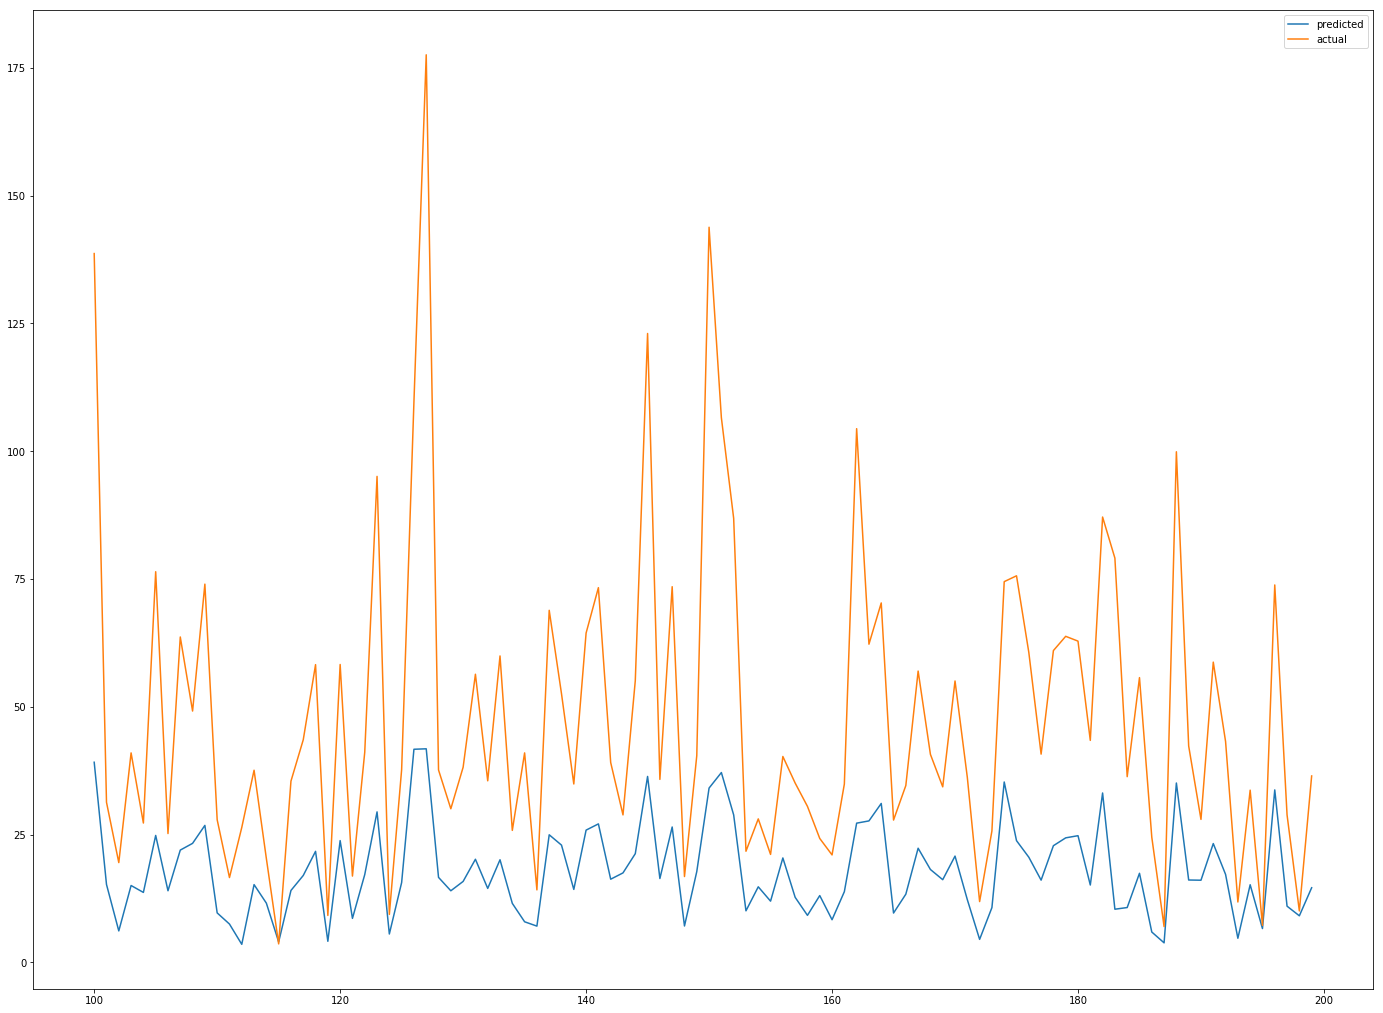

In [6]:
if __name__=='__main__':
    print('Training RMSE :', math.sqrt(mean_squared_error(_Y_TR, Y_TR)))
    print('Validation RMSE :', math.sqrt(mean_squared_error(_Y_VA, Y_VA)))
#     print('Test RMSE :', math.sqrt(mean_squared_error(_Y_TE, Y_TE)))
    
    plot_predicted, = plt.plot(_Y_VA[100:200], label='predicted')
    plot_train, = plt.plot(Y_VA[100:200], label='actual')
    plt.legend(handles=[plot_predicted, plot_train])

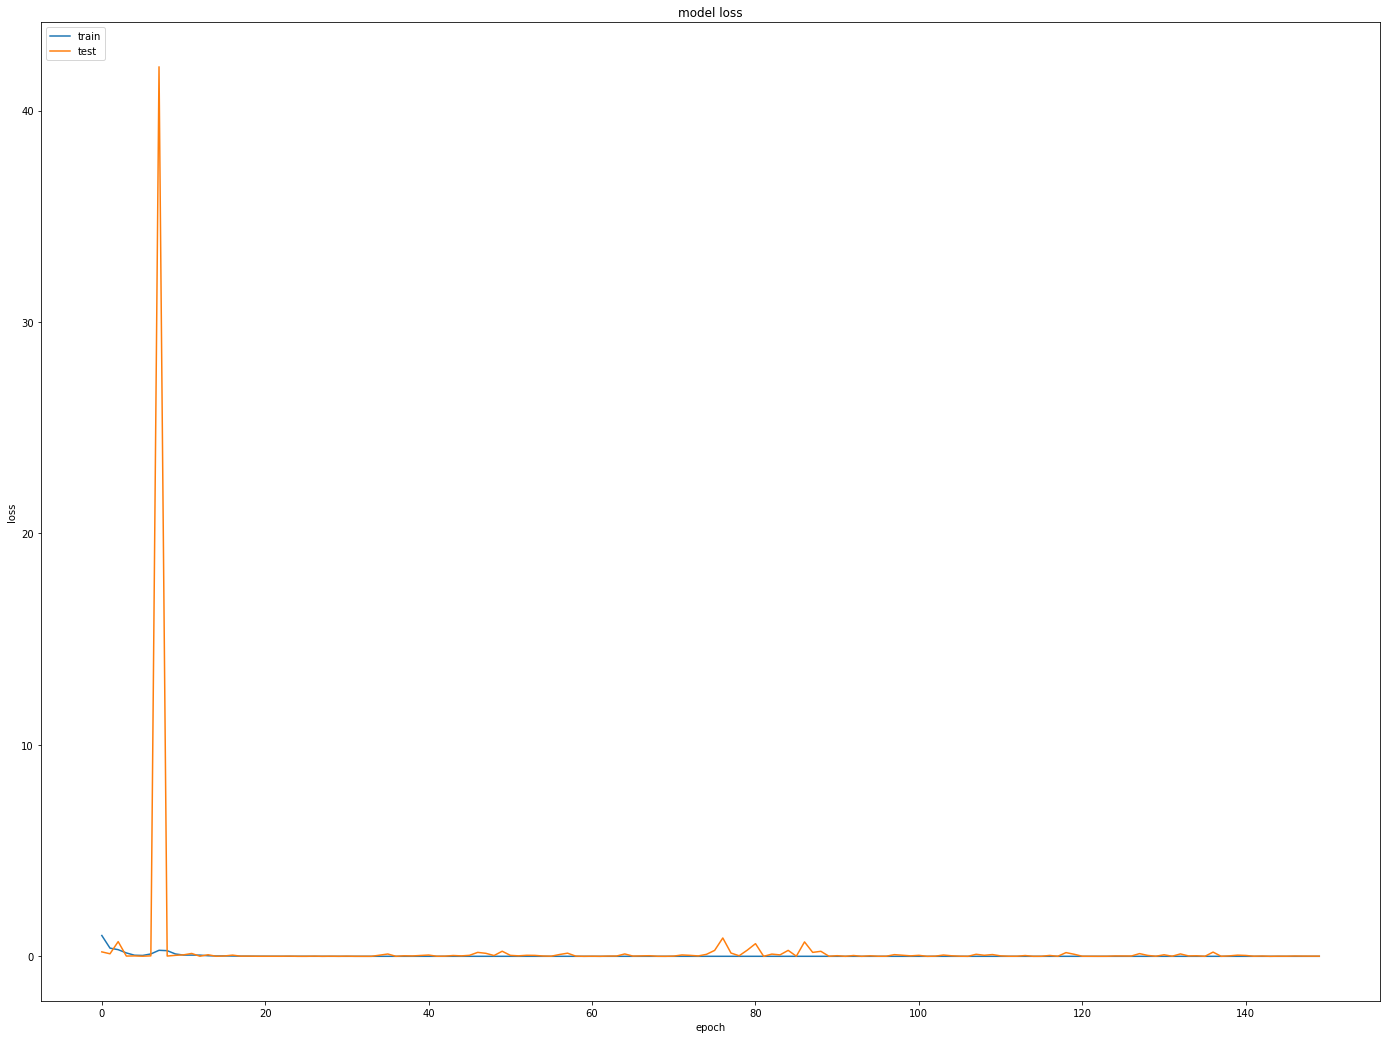

In [7]:
# summarize history for loss
plt.plot(mod_hist.history['loss'])
plt.plot(mod_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()